# Combine CO2 concentration Estimates

Purpose: Combine atmospheric CO2 concentration estimates from Julian years 1-2017, from references at the end of this notebook, and do a logistic fit to the year 200-1749 estimates.

In [1]:
%reset -f
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
os.chdir('C:\\Users\\cd7\\Desktop\\Heat17CO2')

Read three input files separately and assign the year values and carbon dioxide concentration data

In [2]:
df1 = pd.read_excel('cage17lawdome1-2004nov02_ud.xlsx')
df1.to_csv('cage17lawdome1-2004nov02_ud.csv',header=False,index=False)
df1 = pd.read_csv('cage17lawdome1-2004nov02_ud.csv')
df1.drop(df1.index[[-1]],inplace=True)
df1.drop(df1.columns[5], axis=1,inplace=True)

df2 = pd.read_excel('NOAA_MoleFractions_2016_ud.xlsx')
df2.to_csv('NOAA_MoleFractions_2016_ud.csv',header=False,index=False)
df2 = pd.read_csv('NOAA_MoleFractions_2016_ud.csv')
df2.drop(df2.index[[-1]],inplace=True)

df3 = pd.read_excel('NOAAESRL_CO2.xlsx')
df3.to_csv('NOAAESRL_CO2.csv',header=False,index=False)
df3 = pd.read_csv('NOAAESRL_CO2.csv')
df3.drop(df3.index[[-1]],inplace=True)
df3.drop(df3.columns[2:6], axis=1,inplace=True)

Prepare for the nomenclature for the output excel sheet

In [3]:
out1 = 'heat'
out2 = 'co2-1-2017'
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'] # abbreviations for months to insert in output file name
date = datetime.date.today().strftime("%Y-%m-%d")
date_split = date.split('-') # split the date string we create by symbol "-"
yrs = str(int(date_split[0])-2000) # real years minus 2000 
seq = [out1, yrs, out2,months[int(date_split[1])-1],date_split[2]]
seperator = ','
filename = seperator.join(seq).replace(',', '')

Combine CO2 concentration estimates, after rescaling Law Dome to NOAA

In [4]:
yrslaw = df1.iloc[:,0:1]
newyrslaw = yrslaw['YearAD'].tolist()
newyrslaw = list(map(float, newyrslaw))
co2law = df1.iloc[:, 3:4]
# print (co2law)
df1 = pd.merge(yrslaw,co2law, left_index =True, right_index =True,how='outer')
df1 = df1.astype(float)
yrsnoaa = df2.iloc[:,0:1]
yrsnoaa = yrsnoaa['Year'].tolist()
yrsnoaa = list(map(float, yrsnoaa))
newyrsnoaa = [x -0.5 for x in yrsnoaa]
yrsnoaa = list(map(str, newyrsnoaa))
yrsnoaa = pd.DataFrame({'Year':yrsnoaa})
noaa = len(yrsnoaa)
co2noaa = df2.iloc[:,1:2]
# print (co2noaa)
df2 = pd.merge(yrsnoaa,co2noaa, left_index =True, right_index =True,how='outer')
df2 = df2.astype(float)
c1 = newyrsnoaa
c2 = newyrslaw
yrsboth = list(set(c1) & set(c2))
a = yrsboth[0]
b = yrsboth[-1]
co2lawboth = co2law[newyrslaw.index(a):newyrslaw.index(b)+1]
co2noaaboth = co2noaa[0:len(yrsboth)]
co2noaaboth = co2noaaboth['CO2'].tolist()
co2noaaboth = list(map(float, co2noaaboth))
co2lawboth = co2lawboth['CO2spl'].tolist()
co2lawboth = list(map(float, co2lawboth))
rescalelaw = co2noaaboth[0]/co2lawboth[0]

ratio2017vs2016 = float(df3.iloc[-1,-1])/float(df3.iloc[-2,-1])
yrs = list(range(1, 2018))
co2law = co2law.astype(float)
co2law *= float(rescalelaw)
co2law.drop(co2law.index[-int((1+newyrslaw[-1]-newyrsnoaa[0])):-1],inplace=True,axis=0) 
co2law = co2law[:-1]
co2law = co2law['CO2spl'].tolist()
co2law = list(map(float, co2law))
co2noaa = co2noaa['CO2'].tolist()
co2noaa = list(map(float, co2noaa))
last = ratio2017vs2016*co2noaa[-1]
last = [float(last)]
co2 = co2law + co2noaa + last
co2pre = co2[yrs.index(200):yrs.index(1749)+1]
yrspre = range(200,1750)
# print (co2)

Define the fitted logistic function and do Logistic fit to  <CO2>  extrapolated into the industrial era

In [5]:
def logistic(yrspre,c0,c1,c2,c3):
     y = c1 / (1 + np.exp(-(yrspre-c2)/c3))+c0
     return y
param_bounds=([200,-5,1300,0],[300,5,1800,5])
popt,pcov = curve_fit(logistic, yrspre, co2pre, bounds=param_bounds)
print (popt)
print (popt[0]+popt[1])

[ 2.81794576e+02 -3.94171798e+00  1.59382900e+03  1.36702770e+00]
277.8528581584792


C:\Users\cd7\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Explain overflow: Due to we got a large power of around 1000 of exponential function, so it is overflow.

Plot the fitted logistic function,comparing with the historical data and save the results as a csv file.

C:\Users\cd7\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


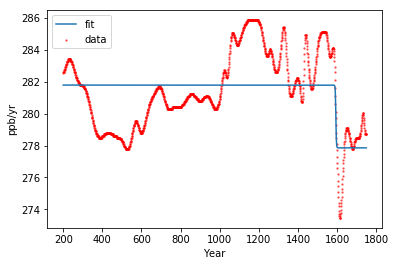

In [6]:
x = np.array(yrspre)
y = logistic(x, *popt)
plt.plot(x,y, label="fit")
plt.xlabel('Year')
plt.ylabel('ppb/yr') 
plt.scatter(yrspre,co2pre,s=2,color = 'r', alpha = 0.5,label ='data',marker='o')
plt.legend(loc='best')
plt.savefig('co21.eps',dpi=1000)
plt.savefig('co21.pdf',dpi=1000)
plt.show()

yrs = list(map(str, yrs))
yrs = pd.DataFrame({'Year':yrs})
co2 = list(map(str, co2))
co2 = pd.DataFrame({'CO2':co2})
df = pd.merge(yrs, co2, left_index =True, right_index =True,how='outer')
df.loc[-1]=['Julian','ppb']
df.index = df.index+1
df = df.sort_index()
df.loc[(len(df))] = ['2018/6/14','heat17co2dec14.nb']
df.to_csv(filename + '.csv', index=False)